### Goal: build a machine learning model to predict the probability that the first transaction of a new user is fradulent

### Agenda:<br/>
1.Determine each user's country based on the numeric IP address<br/>
2.Build a model to predict if an activity is fraudulent or not <br/>
- How different assumptions about the cost of false positives vs false negatives would impact the model
3. Explain how the model predicts from the user perspective?<br/>
- What kind of characteristics are more likely to be classified as at risk?<br/>
4. Explain how a user would use the model from the producttive perspective? = What kind of different user experiences would you build based on the model output?<br/>

In [8]:
import pandas
import numpy as np
pandas.set_option('display.max_columns', 20)
pandas.set_option('display.width', 350)

In [9]:
data=pandas.read_csv('/Users/brandy/Desktop/Takehome/04-Fraud/Fraud_Data.csv')  
data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [10]:
country=pandas.read_csv('/Users/brandy/Desktop/Takehome/04-Fraud/IpAddress_to_Country.csv')
country.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


### Join two tables -- basic info and country
### 1.Determine each user's country based on the numeric IP address
#### = Add column country to the table data

In [11]:
# by using common key: ip_address
# ip_address in the table data is a number
# ip_address in the table country is a range
# so match them by finding data.loc[i, 'ip_address'] within country's ip_address range

# considering two conditions: country 1. has values 2. no values = NA
countries = []
for i in range(len(data)):
    ip_address = data.loc[i, 'ip_address'] 
    tmp = country[(country['lower_bound_ip_address'] <= ip_address) &
                          (country['upper_bound_ip_address'] >= ip_address)]
    if len(tmp) == 1:  #1 = Find the assigned value, 0 means no found
        countries.append(tmp['country'].values[0])
    else:
        countries.append('NA') # considering another conditions: NA value
        
data['country'] = countries

data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NA
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States


### 2.Build a model to predict if an activity is fraudulent or not

1. How different assumptions about the cost of false positives vs false negatives would impact the model<br/>
2. Explain how the model predicts from the user perspective?<br/>
3. What kind of characteristics are more likely to be classified as at risk?<br/>
4. Explain how a user would use the model from the producttive perspective? = What kind of different user experiences would you build based on the model output?<br/>

#### feature engineering
• Time difference between sign-up time and purchase time<br/> 
• If the device id is unique or certain users are sharing the same device<br/> 
(many different user ids using the same device could be an indicator of fake accounts)<br/> 
• Same for the ip address. Many different users having the same ip address could be an indicator of fake accounts<br/>
• Usual week of the year and day of the week from time variables

In [12]:
# Get the time difference between purchase time and signup time 

#make them dates
data["signup_time"]   = pandas.to_datetime(data["signup_time"])
data["purchase_time"] = pandas.to_datetime(data["purchase_time"])

# using lambda x=x.seconds
time_diff = data['purchase_time']-data['signup_time']
time_diff = time_diff.apply(lambda x:x.seconds) #!!
data['time_diff'] = time_diff 

In [13]:
# Check user number for unique devices
# .transform('count') # 计算一个值在测试的'device_id'列中出现的次数.
# The reason why'device_id' shows for 2 times??
data['device_num'] = data.groupby('device_id')['device_id'].transform('count') 

In [14]:
# Check user number for unique ip_address
data['ip_num'] = data.groupby('ip_address')['ip_address'].transform('count')

In [15]:
# Signup day and week
data['signup_day'] = data['signup_time'].apply(lambda x:x.dayofweek)
data['signup_week'] = data['signup_time'].apply(lambda x:x.week)

# Purchase day and week
data['purchase_day'] = data['purchase_time'].apply(lambda x:x.dayofweek)
data['purchase_week'] = data['purchase_time'].apply(lambda x:x.week)

In [16]:
data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,time_diff,device_num,ip_num,signup_day,signup_week,purchase_day,purchase_week
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,13882,1,1,1,9,5,16
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,17944,1,1,6,23,0,24
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,1,12,12,3,1,3,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NA,60085,1,1,1,18,0,19
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,41461,1,1,1,30,2,37


In [17]:
# data set for the model. Drop first 3 vars and device id.
data_rf = data.drop(['user_id', 'signup_time', 'purchase_time', 'device_id'],axis=1)


In [18]:
#just keep the top 50 country, everything else is "other" # Top 50 countries have stronger influence
#get countries from 51 to last one
bottom_countries = data_rf.groupby('country').size().sort_values(ascending=False)[50:].index
x = dict.fromkeys(bottom_countries, 'Other')
data_rf['country'] = data_rf['country'].replace(x)

In [19]:
from sklearn.ensemble import RandomForestClassifier
from numpy.core.umath_tests import inner1d
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from datetime import datetime

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  


In [20]:
# Make dummy  # why need??? Sklearn needs numerical values to learn
# Although tree-based classifier can handle categorical valeus
data_rf = pandas.get_dummies(data_rf, drop_first=True) # drop_first=True drop the first line (index = 0)
  
#split into train and test to avoid overfitting
train, test = train_test_split(data_rf, test_size = 0.34)  # why 0.34??? Default

#### 1.使模型预测更好的特征<br/> 
A: max_features<br/> 
增加max_features一般能提高模型的性能，因为在每个节点上，我们有更多的选择可以考虑。 然而，这未必完全是对的，因为它**降低了单个树的多样性**，而这正是随机森林独特的优点。 但是，可以肯定，你通过增加max_features会**降低算法的速度**。 因此，你需要**适当的平衡和选择最佳max_features。

B. n_estimators：<br/> 
在利用最大投票数或平均值来预测之前，你想要建立子树的数量。 较多的子树可以让**模型有更好的性能**，但同时让你的代码**变慢**。 你应该**选择尽可能高的值，只要你的处理器能够承受的住，因为这使你的预测更好更稳定。

#### 2.使得模型训练更容易的特征<br/> 
C. oob_score：<br/> 
这是一个**随机森林交叉验证方法**。 它和留一验证方法非常相似，但这**快很多**。 这种方法只是简单的**标记在每颗子树中用的观察数据**。 然后对每一个观察样本找出一个**最大投票得分**，是**由那些没有使用该观察样本进行训练的子树投票得到。

Fit(): Method calculates the parameters μ and σ and saves them as internal objects.<br/> 
Fit()求得训练集X的均值，方差，最大值，最小值这些训练集X固有的属性。可以理解为一个训练过程

In [21]:
#build the model
# oob_score: 未使用的样本就叫（Out_of_bag）袋外样本，通过袋外样本，可以评估这个树的准确度
rf = RandomForestClassifier(n_estimators=100, max_features=3, oob_score=True) # why 3?
rf.fit(train.drop('class', axis=1), train['class']) #用训练器数据拟合分类器模型
  
#let's print OOB accuracy and confusion matrix
print(
"OOB accuracy is", 
rf.oob_score_, 
"\n", 
"OOB Confusion Matrix", 
"\n",
pandas.DataFrame(confusion_matrix(train['class'], rf.oob_decision_function_[:,1].round(), labels=[0, 1]))
)

OOB accuracy is 0.9567745881503614 
 OOB Confusion Matrix 
        0     1
0  90418     8
1   4303  5004


In [22]:
#and let's print test accuracy and confusion matrix
print(
"Test accuracy is", rf.score(test.drop('class', axis=1),test['class']), 
"\n", 
"Test Set Confusion Matrix", 
"\n",
pandas.DataFrame(confusion_matrix(test['class'], rf.predict(test.drop('class', axis=1)), labels=[0, 1]))
)

Test accuracy is 0.9562272523793768 
 Test Set Confusion Matrix 
        0     1
0  46534     1
1   2248  2596


Over-fitting: 对于行采样，采用有放回的方式，也就是在采样得到的样本集合中，可能有重复的样本。假设输入样本为N个，那么采样的样本也为N个。这样使得在训练的时候，每一棵树的输入样本都不是全部的样本，使得相对不容易出现over-fitting。

### Summary: <br/>
OOB accuracy is 0.9564838117774458<br/> 
Test accuracy is 0.9567722221140933<br/> 
It is not overfitting given that OOB and test results are very similar. 

Class 0 error: 2219/(2219+46641)=4.54%<br/>
class 1 error：2/（2+2517）=0.07% almost zero

### 1. How different assumptions about the cost of false positives vs false negatives would impact the model<br/>

To gain false positives and false negatives, build the ROC and look for possible cut-off points
* In general, especially when dealing with **fraud, should always do the cut-off analysis.** Default cut-off = 0.5

In [26]:
# We can double check that with a 0.5 cut-off we get the same results shown by rf output
# (since random forest internally uses 0.5)
#Predictions as probabilities
pred_prob=rf.predict_proba(test.drop('class', axis=1))[:,1] #??[:,1] 
#Predictions as actual classes
pred = rf.predict(test.drop('class', axis=1)) #??
  
#Use 0.5 cutoff for probabilities. I.e. if larger > 0.5, predict 1, else predict 0. 
#A short cut for this is using round function, which does exactly the same. If > 0.5, rounds to 1, else rounds to 0. 
#Check if they are the same:
print(np.array_equal(pred_prob.round(), pred))

True


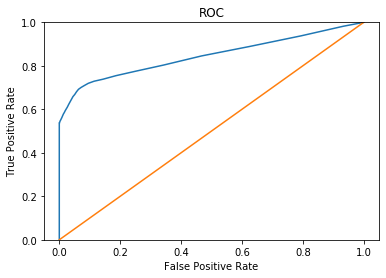

In [27]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
#Let's get false positive rate and true positive rate and plot them in the ROC
fpr, tpr, thresholds = roc_curve(test['class'],pred_prob)
#plot
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1])
plt.ylim([0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.show()

#### 2 options
Option 1: maximize FP (default random forest output) <br/>
TP=0.6 & FP=0.0 <br/>
40% of True account might be wrongly detected as fake accounts, while no fake account will be wrongly detectded as true.

Option 2: maximize TP <br/>
TP>0.8 & FP=[0.4,1]

Only 20% of True account might be wrongly detected as fake accounts, while fake account will be wrongly detectded as true from range 40% to 100%.

#### How to decide? Check class0 error and class1 error

In [29]:
# class0_error = fpr and class1_error = 1 - tpr
error_cutoff=pandas.DataFrame({'cutoff':pandas.Series(thresholds),
                               'class0_error':pandas.Series(fpr),
                               'class1_error': 1 - pandas.Series(tpr)
                                })
error_cutoff['optimal_value'] = 1 - error_cutoff['class1_error'] - error_cutoff['class0_error']
print(error_cutoff.sort_values('optimal_value', ascending=False).head(1))

    cutoff  class0_error  class1_error  optimal_value
44    0.11      0.082799      0.293074       0.624127


### Summary
The best value is in the area near (68%) true positive rate (1-0.32)<br/>
very low false positive rate (7%).<br/>
#### So option 1 is choosen

### 2. Explain how the model predicts from the user perspective?<br/>
1.	If predicted fraud probability < X, the user has the **normal experience** (the high majority of users should fall here)

2.	If X <= predicted fraud probability < Z (so the user is **at risk, but not too much**), you can create an **additional verification step**, like **phone number verifications** via a code sent by SMS or asking to **log in via social network accounts**

3.	If predicted fraud probability >= Z (so here is really likely the user is trying to commit a fraud), you can tell the user **his activity has been put on hold**, send this user info to someone who **reviews it manually**, and finally either **block the user or decide it is not a fraud so the session is resumed**


### Goal: predict the probability that the first transaction of a new user is fradulent
**Success Matrics**:<br/> OOB accuracy ~Test accuracy<br/>
If launch: Yes<br/>
Confusion matrix: almost zero class error 0 & class error 1<br/>

**If users benefit**: Yes<br/>
1. Normal Exeprience
2. Additional verification step: phone number verification/log in via social network accoutns
3. Put the account on hold, customer service professional reviews it manually --> Block or resume the account
Better protect users' account from being stolen
Increase the security

**How to test**: ROC Curve <br/>
**The largest challenge for me?**
1. Feature engineering 
2. ROC: how to choose the cost of false positives vs false negatives that impacts the model

### Open Discussion
3. What kind of characteristics are more likely to be classified as at risk?<br/>
4. Explain how a user would use the model from the producttive perspective? = What kind of different user experiences would you build based on the model output?<br/>